# Diabetes Classification

This project focuses on building a machine learning model that analyzes health indicators such as blood pressure, cholesterol and physical activity to classify patients with Type 2 Diabetes.

The training data is based on results from health surveys that were conducted by the Center for Disease Control (CDC) on 400,000 people.

The model is based on the XGBoost algorithm and has recall score of 78% during cross-validation.

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# set display options
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

# set style and palette
sns.set_theme(style = 'dark')

In [2]:
# load dataset
df = pd.read_csv('health_data.csv')

## Preprocessing

In [3]:
df.info(show_counts = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Diabetes_012          float64
 1   HighBP                float64
 2   HighChol              float64
 3   CholCheck             float64
 4   BMI                   float64
 5   Smoker                float64
 6   Stroke                float64
 7   HeartDiseaseorAttack  float64
 8   PhysActivity          float64
 9   Fruits                float64
 10  Veggies               float64
 11  HvyAlcoholConsump     float64
 12  AnyHealthcare         float64
 13  NoDocbcCost           float64
 14  GenHlth               float64
 15  MentHlth              float64
 16  PhysHlth              float64
 17  DiffWalk              float64
 18  Sex                   float64
 19  Age                   float64
 20  Education             float64
 21  Income                float64
dtypes: float64(22)
memory usage: 42.6 MB


In [4]:
# total missing values in each column
df.isna().sum()

Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [5]:
# check for duplicates
# print(df.duplicated().any())

# no. of duplicates
# print('No. of duplicates: {}'.format(df.duplicated().sum()))

# remove duplicates
df = df[~df.duplicated()]

In [6]:
# rename columns
df.columns = ['target', 'high_bp', 'high_cholesterol', 'cholesterol_checked_in_5_years', 'bmi', 'current_or_past_smoking',
              'stroke', 'heart_disease_or_attack', 'physical_activity', 'any_fruits_per_day', 'any_veggies_per_day',
              'heavy_alcohol_intake', 'healthcare_coverage', 'no_healthcare_access_due_to_cost', 'overall_health_ordinal',
              'days_mental_health_affected', 'days_physical_health_affected', 'difficulty_walking_or_climbing', 'male', 'age_bucket_ordinal', 'education_ordinal',
              'income_ordinal']

# reorder columns
df = df[['age_bucket_ordinal', 'education_ordinal', 'income_ordinal', 'male', 'bmi', 'physical_activity', 'current_or_past_smoking', 'heavy_alcohol_intake', 'any_fruits_per_day', 'any_veggies_per_day',
        'difficulty_walking_or_climbing', 'high_bp', 'high_cholesterol', 'cholesterol_checked_in_5_years', 'stroke', 'heart_disease_or_attack',
        'healthcare_coverage', 'no_healthcare_access_due_to_cost', 'overall_health_ordinal', 'days_physical_health_affected', 'days_mental_health_affected', 'target']]

In [7]:
# convert dtypes
vars = ['age_bucket_ordinal', 'education_ordinal', 'income_ordinal', 'male', 'physical_activity', 'current_or_past_smoking', 'heavy_alcohol_intake', 'any_fruits_per_day', 'any_veggies_per_day',
        'difficulty_walking_or_climbing', 'high_bp', 'high_cholesterol', 'cholesterol_checked_in_5_years', 'stroke', 'heart_disease_or_attack',
        'healthcare_coverage', 'no_healthcare_access_due_to_cost', 'overall_health_ordinal', 'days_physical_health_affected', 'days_mental_health_affected', 'target']

for var in vars:
    df[var] = df[var].astype('int')

In [8]:
df.describe()

,age_bucket_ordinal,education_ordinal,income_ordinal,male,bmi,physical_activity,current_or_past_smoking,heavy_alcohol_intake,any_fruits_per_day,any_veggies_per_day,difficulty_walking_or_climbing,high_bp,high_cholesterol,cholesterol_checked_in_5_years,stroke,heart_disease_or_attack,healthcare_coverage,no_healthcare_access_due_to_cost,overall_health_ordinal,days_physical_health_affected,days_mental_health_affected,target
count,229781.000000,229781.000000,229781.000000,229781.000000,229781.00000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000,229781.000000
mean,8.086582,4.980568,5.890383,0.439231,28.68567,0.733355,0.465661,0.060710,0.612966,0.794813,0.185507,0.454441,0.441760,0.959535,0.044756,0.103216,0.946075,0.092810,2.601151,4.675178,3.505373,0.325627
std,3.093809,0.992895,2.092477,0.496295,6.78636,0.442206,0.498821,0.238798,0.487073,0.403839,0.388709,0.497921,0.496598,0.197047,0.206767,0.304241,0.225871,0.290167,1.064685,9.046568,7.713725,0.724623
min,1.000000,1.000000,1.000000,0.000000,12.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,6.000000,4.000000,5.000000,0.000000,24.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000
50%,8.000000,5.000000,6.000000,0.000000,27.00000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000
75%,10.000000,6.000000,8.000000,1.000000,32.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000,4.000000,2.000000,0.000000
max,13.000000,6.000000,8.000000,1.000000,98.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,30.000000,30.000000,2.000000


In [9]:
# drop rows for pre-diabetes
df = df[~(df['target'] == 1)]

# classify diabetes as 1
df.loc[df['target'] == 2, 'target'] = 1

In [10]:
# detect outliers
vars = ['bmi', 'days_physical_health_affected', 'days_mental_health_affected']
l = []

for var in vars:
    q1 = np.percentile(df[var], 25, method = 'midpoint')
    q3 = np.percentile(df[var], 75, method = 'midpoint')
    
    lower_bound = q1 - 1.5*(q3-q1)
    upper_bound = q3 + 1.5*(q3-q1)

    n_outliers = ((df[var] < lower_bound) | (df[var] > upper_bound)).sum()
    l.append([var, lower_bound, upper_bound, n_outliers])

df_outliers = pd.DataFrame(l, columns = ['variable', 'lower_bound', 'upper_bound', 'n_outliers'])
df_outliers

,variable,lower_bound,upper_bound,n_outliers
0,bmi,12.0,44.0,5462
1,days_physical_health_affected,-6.0,10.0,33372
2,days_mental_health_affected,-3.0,5.0,35228


In [11]:
# remove outliers
for row in l:
    var = row[0]
    lower_bound = row[1]
    upper_bound = row[2]

    df = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]

In [12]:
# reset index
df = df.reset_index(drop = True)

## Exploratory Analysis

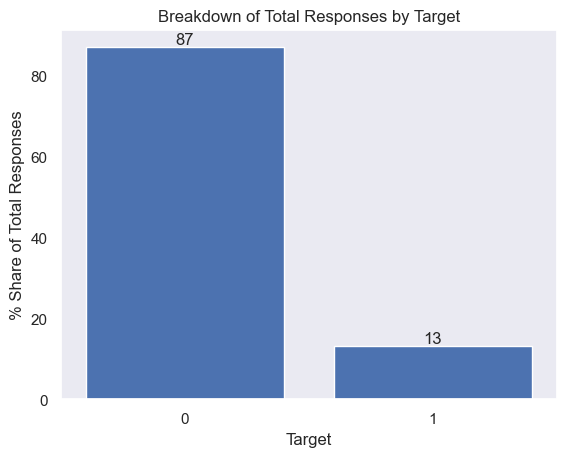

In [13]:
fig, ax = plt.subplots()
sns.countplot(x = df['target'], saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.0f')
ax.set_title('Breakdown of Total Responses by Target')
ax.set_xlabel('Target')
ax.set_ylabel('% Share of Total Responses')
plt.show()

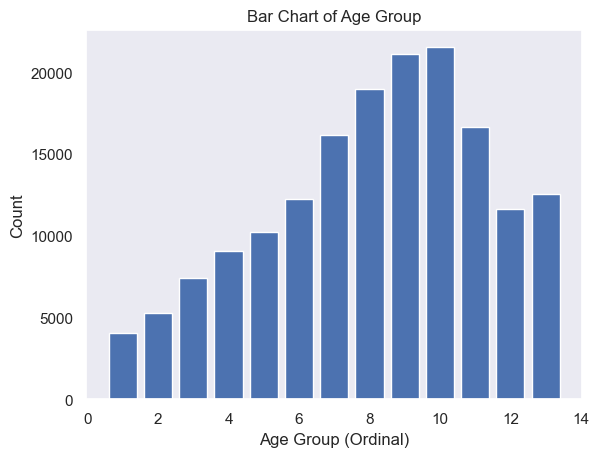

In [14]:
fig, ax = plt.subplots()
sns.histplot(x = df['age_bucket_ordinal'], alpha = 1, discrete = True, shrink = 0.8)
ax.set_title('Bar Chart of Age Group')
ax.set_xlabel('Age Group (Ordinal)')
plt.show()

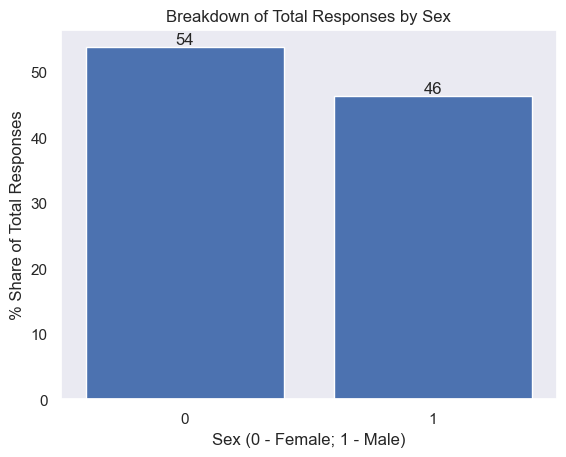

In [15]:
fig, ax = plt.subplots()
sns.countplot(x = df['male'], saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.0f')
ax.set_title('Breakdown of Total Responses by Sex')
ax.set_xlabel('Sex (0 - Female; 1 - Male)')
ax.set_ylabel('% Share of Total Responses')
plt.show()

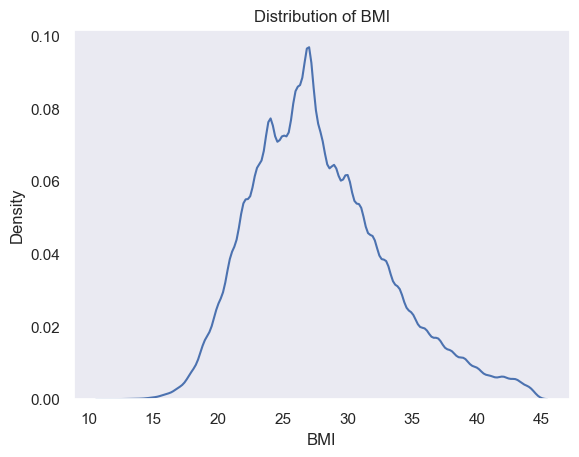

In [16]:
fig, ax = plt.subplots()
sns.kdeplot(x = df['bmi'], alpha = 1)
ax.set_title('Distribution of BMI')
ax.set_xlabel('BMI')
plt.show()

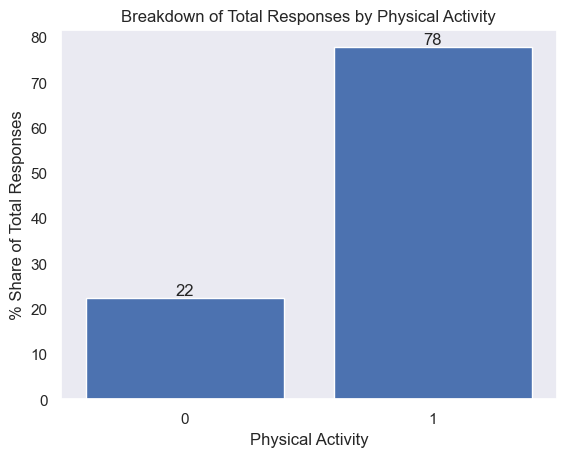

In [17]:
fig, ax = plt.subplots()
sns.countplot(x = df['physical_activity'], saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.0f')
ax.set_title('Breakdown of Total Responses by Physical Activity')
ax.set_xlabel('Physical Activity')
ax.set_ylabel('% Share of Total Responses')
plt.show()

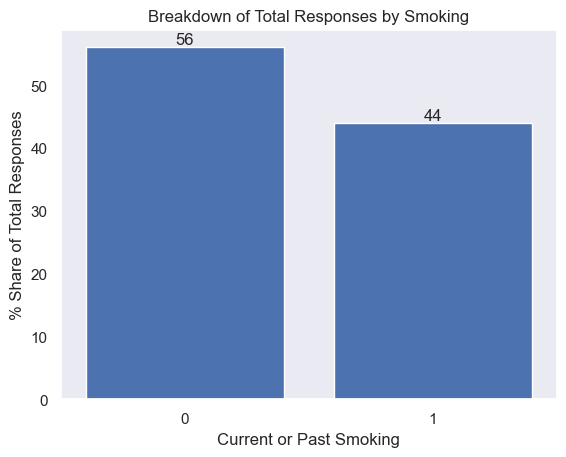

In [18]:
fig, ax = plt.subplots()
sns.countplot(x = df['current_or_past_smoking'], saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.0f')
ax.set_title('Breakdown of Total Responses by Smoking')
ax.set_xlabel('Current or Past Smoking')
ax.set_ylabel('% Share of Total Responses')
plt.show()

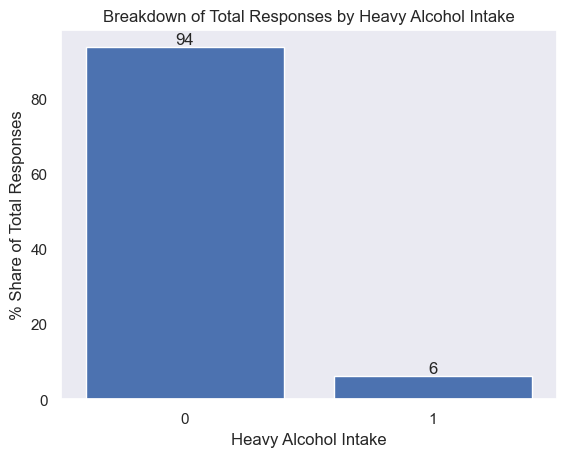

In [19]:
fig, ax = plt.subplots()
sns.countplot(x = df['heavy_alcohol_intake'], saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.0f')
ax.set_title('Breakdown of Total Responses by Heavy Alcohol Intake')
ax.set_xlabel('Heavy Alcohol Intake')
ax.set_ylabel('% Share of Total Responses')
plt.show()

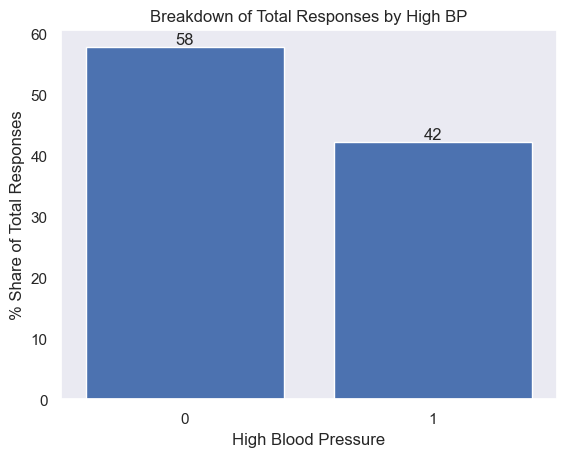

In [20]:
fig, ax = plt.subplots()
sns.countplot(x = df['high_bp'], saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.0f')
ax.set_title('Breakdown of Total Responses by High BP')
ax.set_xlabel('High Blood Pressure')
ax.set_ylabel('% Share of Total Responses')
plt.show()

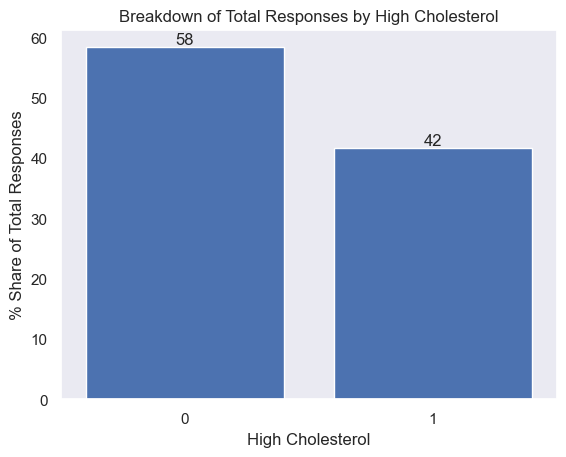

In [21]:
fig, ax = plt.subplots()
sns.countplot(x = df['high_cholesterol'], saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.0f')
ax.set_title('Breakdown of Total Responses by High Cholesterol')
ax.set_xlabel('High Cholesterol')
ax.set_ylabel('% Share of Total Responses')
plt.show()

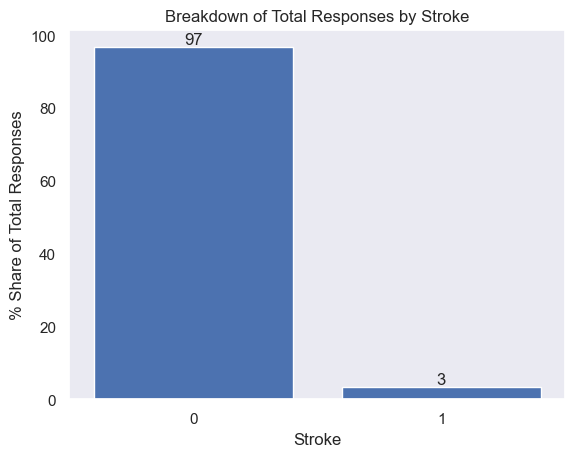

In [22]:
fig, ax = plt.subplots()
sns.countplot(x = df['stroke'], saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.0f')
ax.set_title('Breakdown of Total Responses by Stroke')
ax.set_xlabel('Stroke')
ax.set_ylabel('% Share of Total Responses')
plt.show()

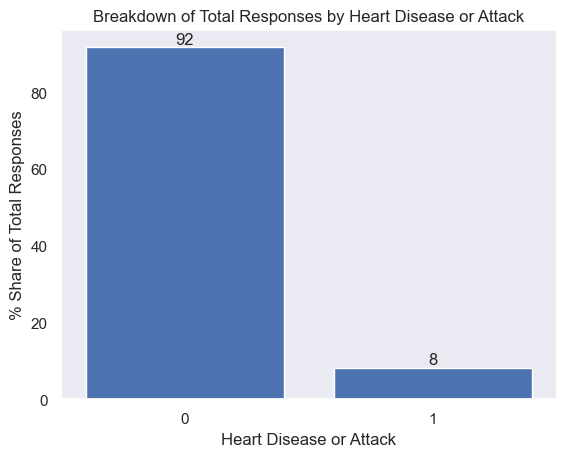

In [23]:
fig, ax = plt.subplots()
sns.countplot(x = df['heart_disease_or_attack'], saturation = 1, stat = 'percent')
ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.0f')
ax.set_title('Breakdown of Total Responses by Heart Disease or Attack')
ax.set_xlabel('Heart Disease or Attack')
ax.set_ylabel('% Share of Total Responses')
plt.show()

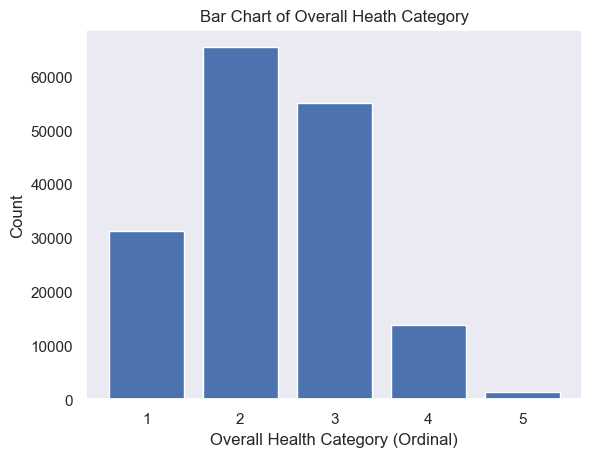

In [24]:
fig, ax = plt.subplots()
sns.histplot(x = df['overall_health_ordinal'], alpha = 1, discrete = True, shrink = 0.8)
ax.set_title('Bar Chart of Overall Heath Category')
ax.set_xlabel('Overall Health Category (Ordinal)')
plt.show()

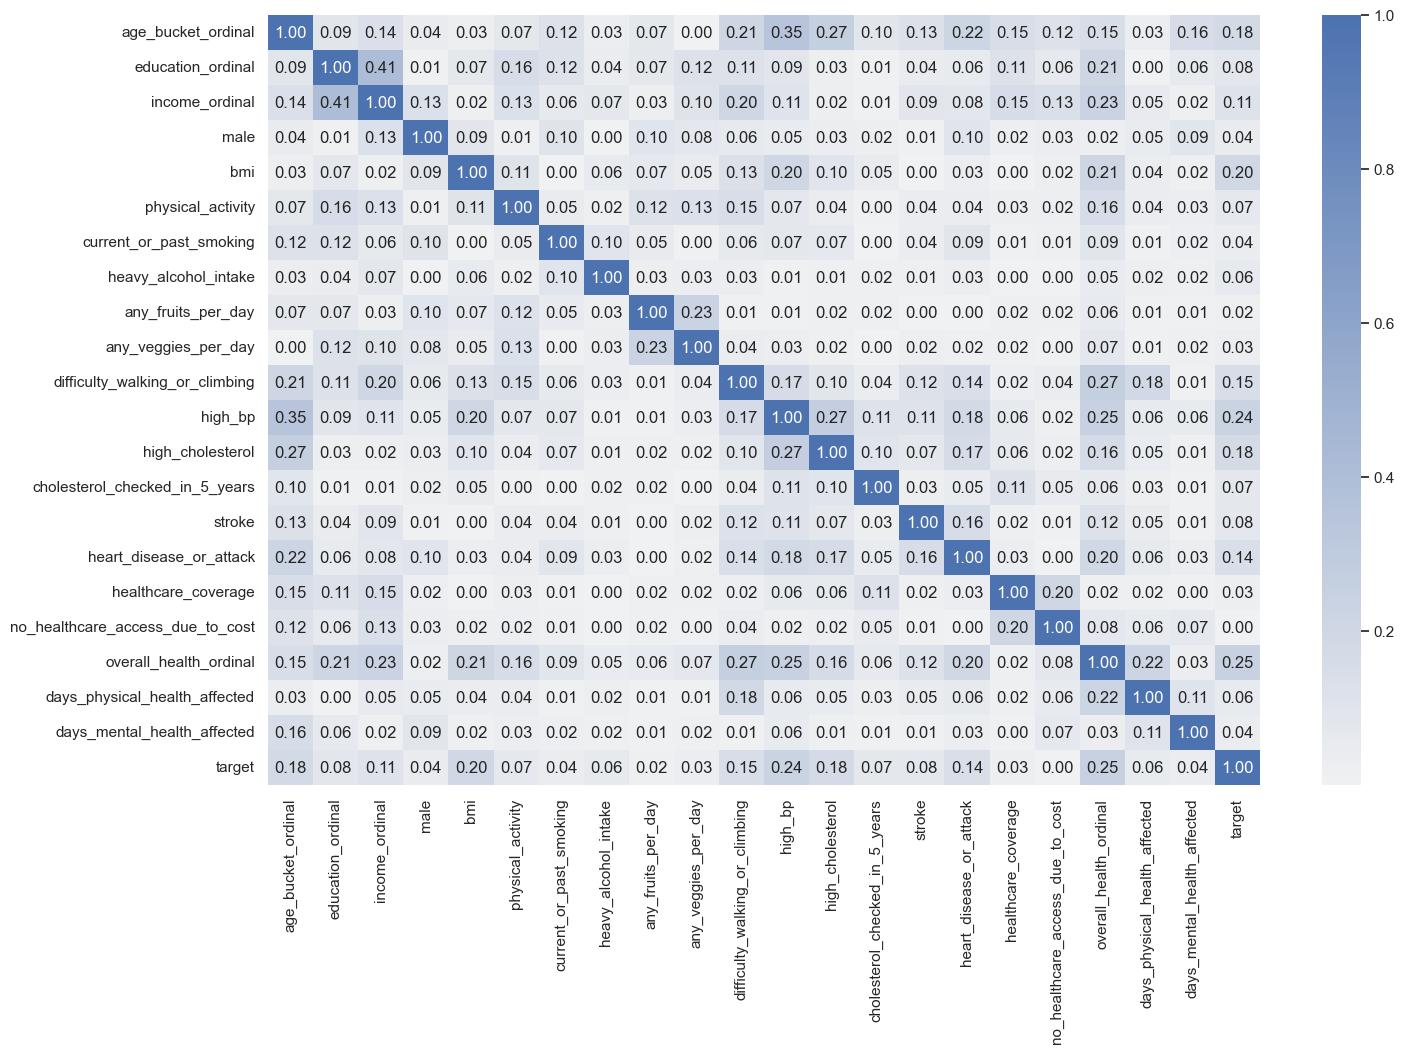

In [25]:
# correlation heatmap
base_color = sns.color_palette("deep")[0]
custom_colormap = sns.light_palette(base_color, as_cmap = True)

correlations = abs(df.corr())

fig, ax = plt.subplots(figsize = (16, 10))
sns.heatmap(correlations, annot = True, cmap = custom_colormap, fmt = '.2f')
plt.show()

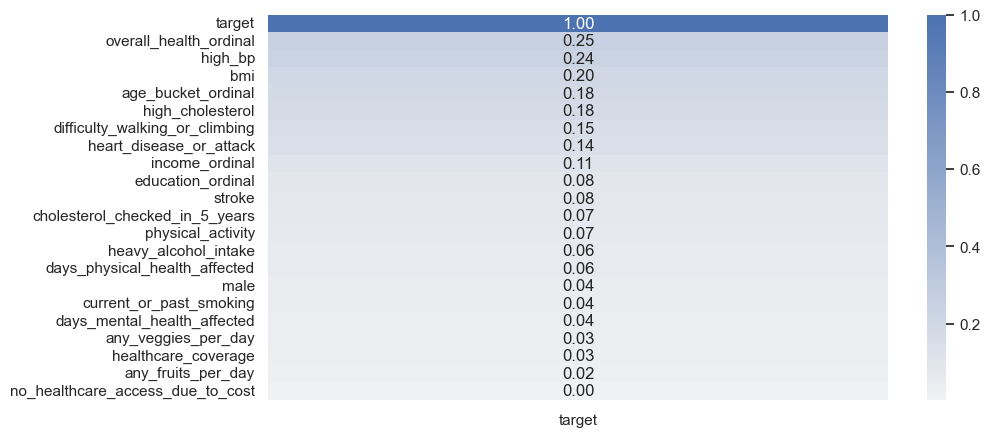

In [26]:
correlations2 = correlations['target'].to_frame().sort_values(by = 'target', ascending = False)

fig, ax = plt.subplots(figsize = (10, 5))
sns.heatmap(correlations2, annot = True, cmap = custom_colormap, fmt = '.2f')
plt.show()

## Train-Test Split

In [27]:
# drop features with low correlation
df.drop(columns = ['any_veggies_per_day', 'male', 'any_fruits_per_day', 'healthcare_coverage', 'no_healthcare_access_due_to_cost'], inplace = True)

In [28]:
# split data into training, validation and testing sets
X = df.drop(columns = 'target')
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, stratify = y, random_state = 42)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2/ 0.8, random_state = 42)

In [29]:
# scale features
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [30]:
# scoring function
def fit_predict(model, X_train, X_val, y_train, y_val):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    
    accuracy = round(model.score(X_val, y_val)*100, 1)
    recall = round(recall_score(y_val, y_pred)*100, 1)
    
    return accuracy, recall

## Model Selection

In [31]:
models = {'Logistic Regression': LogisticRegression(), 'K-NN': KNeighborsClassifier(), 'Random Forest': RandomForestClassifier(),
          'XGBoost': XGBClassifier()}

l = []

for name, model in models.items():
    accuracy, recall = fit_predict(model, X_train, X_val, y_train, y_val)
    l.append([name, accuracy, recall])

report = pd.DataFrame(l, columns = ['Name', 'Accuracy', 'Recall'])
report

,Name,Accuracy,Recall
0,Logistic Regression,87.1,11.3
1,K-NN,85.6,16.4
2,Random Forest,85.2,14.4
3,XGBoost,87.1,11.8


### Balancing Majority and Minority Classes using SMOTE Oversampling

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, stratify = y, random_state = 42)

sm = SMOTE(random_state = 42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

scaler = MinMaxScaler()
X_train_balanced = pd.DataFrame(scaler.fit_transform(X_train_balanced), columns = X_train_balanced.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

models = {'Logistic Regression': LogisticRegression(), 'K-NN': KNeighborsClassifier(), 'Random Forest': RandomForestClassifier(),
          'XGBoost': XGBClassifier()}

l = []

for name, model in models.items():
    accuracy, recall = fit_predict(model, X_train_balanced, X_val, y_train_balanced, y_val)
    l.append([name, accuracy, recall])

scores = pd.DataFrame(l, columns = ['Name', 'Accuracy', 'Recall'])
scores

,Name,Accuracy,Recall
0,Logistic Regression,69.9,72.0
1,K-NN,70.5,53.1
2,Random Forest,78.3,36.9
3,XGBoost,75.5,58.6


### Balancing Majority and Minority Classes using Random Undersampling

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.15, stratify = y, random_state = 42)

rus = RandomUnderSampler(random_state = 42)
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)

scaler = MinMaxScaler()
X_train_balanced = pd.DataFrame(scaler.fit_transform(X_train_balanced), columns = X_train_balanced.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

models = {'Logistic Regression': LogisticRegression(), 'K-NN': KNeighborsClassifier(), 'Random Forest': RandomForestClassifier(),
          'XGBoost': XGBClassifier()}

l = []

for name, model in models.items():
    accuracy, recall = fit_predict(model, X_train_balanced, X_val, y_train_balanced, y_val)
    l.append([name, accuracy, recall])

scores = pd.DataFrame(l, columns = ['Name', 'Accuracy', 'Recall'])
scores

,Name,Accuracy,Recall
0,Logistic Regression,71.8,74.3
1,K-NN,67.7,71.1
2,Random Forest,68.6,73.0
3,XGBoost,70.1,76.6


## Hyperparameter Tuning and Cross-validation

In [34]:
def predict(fitted_model, X_val, y_val):
    
    y_pred = fitted_model.predict(X_val)
    
    accuracy = round(fitted_model.score(X_val, y_val)*100, 1)
    recall = round(recall_score(y_val, y_pred)*100, 1)
    
    return accuracy, recall

In [35]:
# hyperparameter tuning and cross-validation of logistic regression model
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

model = LogisticRegression(random_state = 42)

param_grid = {'penalty': [None, 'l2']}

grid = GridSearchCV(model, param_grid, scoring = 'f1', cv = skf, n_jobs = -1)
grid.fit(X_train_balanced, y_train_balanced)

best_params = grid.best_params_
best_model = grid.best_estimator_

accuracy, recall = predict(best_model, X_val, y_val)
scores = pd.DataFrame([['Tuned Logistic Regression', accuracy, recall]], columns = ['Name', 'Accuracy', 'Recall'])
scores

,Name,Accuracy,Recall
0,Tuned Logistic Regression,71.8,74.4


In [36]:
# hyperparameter tuning and cross-validation of xgboost model
model = XGBClassifier()

param_grid = {'eta': [0.08, 0.1],
              'max_depth': [4, 6],
              'n_estimators': [100, 250, 400]
             }
              
grid = GridSearchCV(model, param_grid, scoring = 'f1', cv = skf, n_jobs = -1)
grid.fit(X_train_balanced, y_train_balanced)

best_params = grid.best_params_
best_model = grid.best_estimator_

accuracy, recall = predict(best_model, X_val, y_val)
scores = pd.DataFrame([['Tuned XGBoost', accuracy, recall]], columns = ['Name', 'Accuracy', 'Recall'])
scores

,Name,Accuracy,Recall
0,Tuned XGBoost,70.8,77.6


In [37]:
# feature importance of xgboost model
feature_importances = pd.DataFrame(best_model.feature_importances_, columns = ['Feature Importance'], index = best_model.get_booster().feature_names).sort_values(by = 'Feature Importance', ascending = False)
feature_importances[:10]

,Feature Importance
high_bp,0.626127
overall_health_ordinal,0.094881
high_cholesterol,0.077249
age_bucket_ordinal,0.039181
bmi,0.035156
cholesterol_checked_in_5_years,0.029814
heavy_alcohol_intake,0.027358
heart_disease_or_attack,0.019141
income_ordinal,0.009982
days_mental_health_affected,0.009297
